In [1]:
!pip install mlflow

     |████████████████████████████████| 16.5 MB 4.0 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 146 kB 48.6 MB/s 
     |████████████████████████████████| 181 kB 42.7 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 210 kB 44.7 MB/s 
     |████████████████████████████████| 58 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=1e974a3937c41b5bea930cd6360ea80876125834d5688dc0646e0d2c7f177e4f
  Stored in directory: /root/.cache/pip/wheels/a2/a1/6d/fa1d22ea25ed8593887437fe1c7e00f6ef307fc240ccd4dc5c
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [12]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [3]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_Test.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.1__2527_3.4_(+68.4056309072,+27.9598835551)_FI_Lapland_Pohjois-Lappi_Ivalo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.9__2833_1.7_(+55.6481165684,+160.0826582390)_RU_Kamtsjatka_nan_Atlasovo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.3__2393_0.0_(+66.0312039483,-137.6865802275)_CA_Yukon_nan_Dawson-City.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3863_0.0_(+56.3322734887,-88.1656925490)_CA_Ontario_nan_Greenstone.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3802_0.0_(+58.3646219875,-100.1384386558)_CA_Manitoba_nan_Thompson.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.7__3003_0.0_(+55.7487278802,-72.7721618404)_CA_Quebec_Nord-d

In [4]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [5]:
## Leemos las imágenes de train, validacion y test
training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [6]:
print(training.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


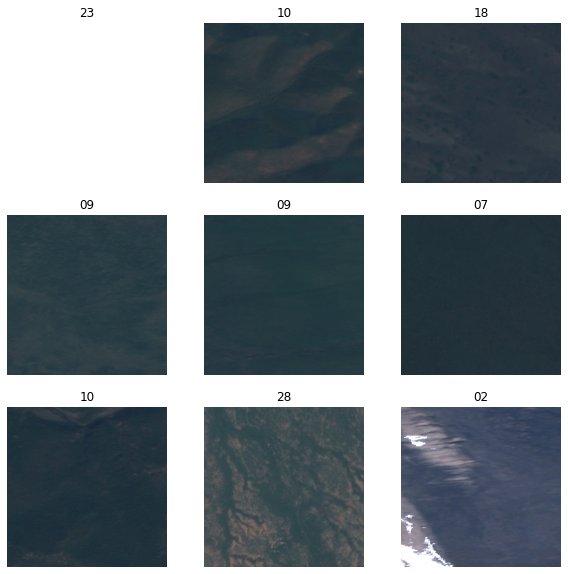

In [7]:
## Mostramos las 9 primeras imagenes de training
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


def predecir_guardar_test(modelo, nombre_salida, test):
    y_pred = modelo.predict(test)
    classes = np.argmax(y_pred, axis=1)
    classes = np.array(classes)
    classes = classes + 1

    d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
    df = pd.DataFrame(data=d)
    df.to_csv(nombre_salida, index=False)

87924736/87910968 [==============================] - 3s 0us/step


2022/03/14 09:27:08 INFO mlflow.tracking.fluent: Experiment with name 'Prueba' does not exist. Creating a new experiment.


Epoch 1/10
257/257 [==============================] - 116s 234ms/step - loss: 1.8162 - accuracy: 0.4800 - val_loss: 1.4195 - val_accuracy: 0.5796
Epoch 2/10
257/257 [==============================] - 56s 217ms/step - loss: 1.2089 - accuracy: 0.6268 - val_loss: 1.2691 - val_accuracy: 0.6020
Epoch 3/10
257/257 [==============================] - 56s 217ms/step - loss: 1.0346 - accuracy: 0.6789 - val_loss: 1.1830 - val_accuracy: 0.6264
Epoch 4/10
257/257 [==============================] - 56s 217ms/step - loss: 0.9195 - accuracy: 0.7124 - val_loss: 1.1667 - val_accuracy: 0.6298
Epoch 5/10
257/257 [==============================] - 56s 216ms/step - loss: 0.8329 - accuracy: 0.7438 - val_loss: 1.1253 - val_accuracy: 0.6357
Epoch 6/10
257/257 [==============================] - 56s 216ms/step - loss: 0.7674 - accuracy: 0.7649 - val_loss: 1.1113 - val_accuracy: 0.6420
Epoch 7/10
257/257 [==============================] - 56s 217ms/step - loss: 0.7121 - accuracy: 0.7806 - val_loss: 1.1000 - val_a

2022/03/14 09:40:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


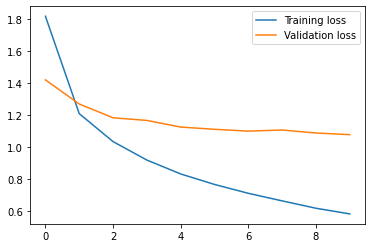

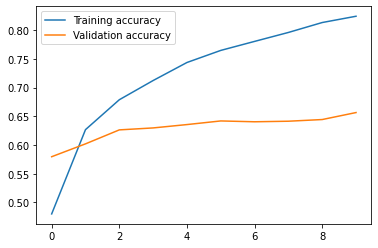

In [17]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=10,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

In [18]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9 12 16]


In [ ]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('resultados_iniciales_inception.csv', index=False)

Epoch 1/30
257/257 [==============================] - 63s 223ms/step - loss: 2.8644 - accuracy: 0.1800 - val_loss: 2.4002 - val_accuracy: 0.2650
Epoch 2/30
257/257 [==============================] - 56s 217ms/step - loss: 1.8817 - accuracy: 0.4174 - val_loss: 1.5492 - val_accuracy: 0.5007
Epoch 3/30
257/257 [==============================] - 56s 217ms/step - loss: 1.2796 - accuracy: 0.5785 - val_loss: 1.3703 - val_accuracy: 0.5558
Epoch 4/30
257/257 [==============================] - 56s 217ms/step - loss: 1.0365 - accuracy: 0.6443 - val_loss: 1.2653 - val_accuracy: 0.5835
Epoch 5/30
257/257 [==============================] - 56s 217ms/step - loss: 0.8869 - accuracy: 0.6923 - val_loss: 1.2439 - val_accuracy: 0.5977
Epoch 6/30
257/257 [==============================] - 56s 216ms/step - loss: 0.7505 - accuracy: 0.7342 - val_loss: 1.2745 - val_accuracy: 0.5957
Epoch 7/30
257/257 [==============================] - 56s 216ms/step - loss: 0.6635 - accuracy: 0.7635 - val_loss: 1.2291 - val_ac

2022/03/14 09:52:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


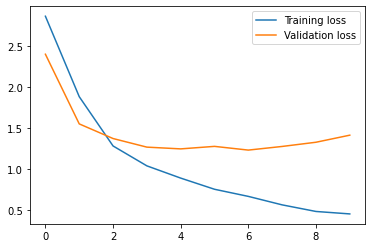

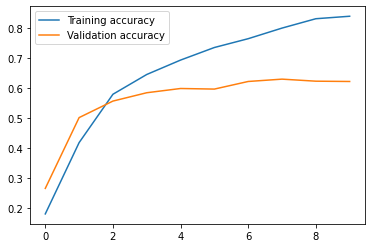

In [22]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  Dense(1024, activation = "relu"),
  Dense(512, activation = "relu"),
  Dense(32, activation = "relu"),
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=30,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "inceptionv3_congelado_dense.csv", test)


In [23]:
batch_size = 32

train_image_generator = ImageDataGenerator(rotation_range = 15, # en este problema tiene sentido que la imagen pueda ser tomada desde cualquier angulo
                                           zoom_range = 0.3,
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           validation_split = 0.2)


training_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')


validation_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')

total_train = 8236
total_val = 2030


Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.


Epoch 1/40
257/257 [==============================] - 149s 560ms/step - loss: 2.5141 - accuracy: 0.2651 - val_loss: 2.0775 - val_accuracy: 0.3780
Epoch 2/40
257/257 [==============================] - 139s 541ms/step - loss: 1.6531 - accuracy: 0.4712 - val_loss: 1.6933 - val_accuracy: 0.4782
Epoch 3/40
257/257 [==============================] - 141s 547ms/step - loss: 1.4293 - accuracy: 0.5332 - val_loss: 1.7391 - val_accuracy: 0.4678
Epoch 4/40
257/257 [==============================] - 140s 543ms/step - loss: 1.3609 - accuracy: 0.5460 - val_loss: 1.5797 - val_accuracy: 0.4990
Epoch 5/40
257/257 [==============================] - 140s 546ms/step - loss: 1.2651 - accuracy: 0.5870 - val_loss: 1.5066 - val_accuracy: 0.5144
Epoch 6/40
257/257 [==============================] - 139s 542ms/step - loss: 1.2311 - accuracy: 0.5963 - val_loss: 1.5804 - val_accuracy: 0.5074
Epoch 7/40
257/257 [==============================] - 137s 533ms/step - loss: 1.1848 - accuracy: 0.6062 - val_loss: 1.3985 -

2022/03/14 10:24:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


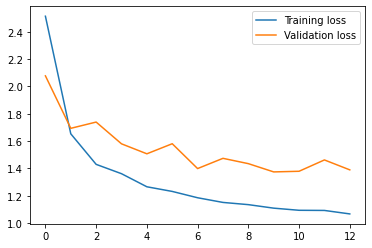

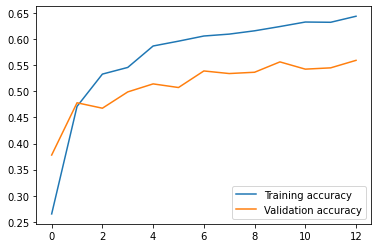

In [24]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  Dense(1024, activation = "relu"),
  Dense(512, activation = "relu"),
  Dense(32, activation = "relu"),
  prediction_layer
])


opt = Adam()
      
model.compile(loss= SparseCategoricalCrossentropy(from_logits = False), optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_data_augmentation")
mlflow.tensorflow.autolog()

# a partir de TF 2.2, fit ya funciona con generadores, no hace falta usar fit_generator
with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training_generator,
                        epochs=40,
                        steps_per_epoch = total_train // batch_size, # si queremos usar más imágenes, aumentar este parametro y validation_steps
                        validation_data = validation_generator,
                        validation_steps = total_val // batch_size,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "inceptionv3_congelado_data_augmentation.csv", test)
  

Epoch 1/40
257/257 [==============================] - 42s 155ms/step - loss: 2.3495 - accuracy: 0.2242 - val_loss: 2.0739 - val_accuracy: 0.2718
Epoch 2/40
257/257 [==============================] - 39s 150ms/step - loss: 1.7569 - accuracy: 0.3754 - val_loss: 1.7313 - val_accuracy: 0.3838
Epoch 3/40
257/257 [==============================] - 39s 150ms/step - loss: 1.6770 - accuracy: 0.4055 - val_loss: 1.7253 - val_accuracy: 0.3658
Epoch 4/40
257/257 [==============================] - 39s 150ms/step - loss: 1.5654 - accuracy: 0.4413 - val_loss: 1.6499 - val_accuracy: 0.3707
Epoch 5/40
257/257 [==============================] - 39s 151ms/step - loss: 1.5488 - accuracy: 0.4465 - val_loss: 1.4264 - val_accuracy: 0.4817
Epoch 6/40
257/257 [==============================] - 39s 150ms/step - loss: 1.4684 - accuracy: 0.4863 - val_loss: 1.4802 - val_accuracy: 0.4618
Epoch 7/40
257/257 [==============================] - 39s 150ms/step - loss: 1.3762 - accuracy: 0.5142 - val_loss: 1.2400 - val_ac

2022/03/14 10:38:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


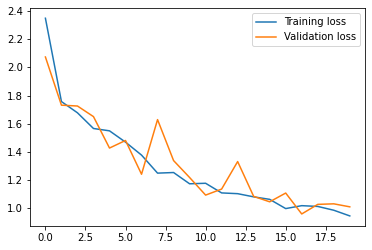

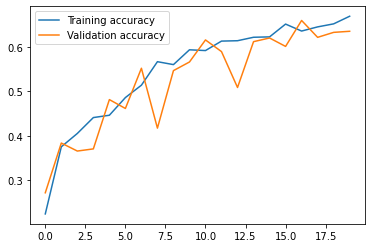

In [25]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(29, activation = "softmax")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=40,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio.csv", test)

Epoch 1/40
257/257 [==============================] - 24s 87ms/step - loss: 2.7909 - accuracy: 0.1091 - val_loss: 2.3834 - val_accuracy: 0.1724
Epoch 2/40
257/257 [==============================] - 22s 85ms/step - loss: 2.2582 - accuracy: 0.2013 - val_loss: 2.2201 - val_accuracy: 0.2109
Epoch 3/40
257/257 [==============================] - 22s 85ms/step - loss: 2.1390 - accuracy: 0.2496 - val_loss: 2.0899 - val_accuracy: 0.2650
Epoch 4/40
257/257 [==============================] - 22s 86ms/step - loss: 2.0213 - accuracy: 0.2926 - val_loss: 2.0150 - val_accuracy: 0.3142
Epoch 5/40
257/257 [==============================] - 22s 84ms/step - loss: 1.9047 - accuracy: 0.3305 - val_loss: 1.7744 - val_accuracy: 0.3415
Epoch 6/40
257/257 [==============================] - 22s 86ms/step - loss: 1.7836 - accuracy: 0.3718 - val_loss: 1.7141 - val_accuracy: 0.3989
Epoch 7/40
257/257 [==============================] - 22s 85ms/step - loss: 1.6535 - accuracy: 0.4191 - val_loss: 1.5416 - val_accuracy:

2022/03/14 10:46:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


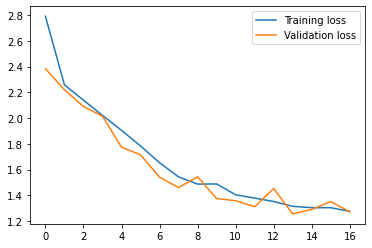

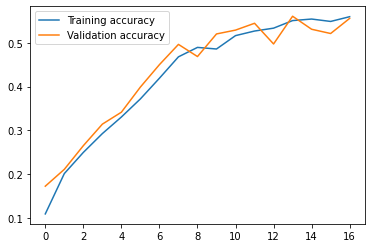

In [26]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(29, activation = "softmax")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=40,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio_reducido.csv", test)

Epoch 1/40
257/257 [==============================] - 131s 506ms/step - loss: 2.8576 - accuracy: 0.1037 - val_loss: 2.4292 - val_accuracy: 0.1691
Epoch 2/40
257/257 [==============================] - 129s 503ms/step - loss: 2.2344 - accuracy: 0.2268 - val_loss: 2.1348 - val_accuracy: 0.2862
Epoch 3/40
257/257 [==============================] - 129s 502ms/step - loss: 1.9322 - accuracy: 0.3256 - val_loss: 1.9347 - val_accuracy: 0.3497
Epoch 4/40
257/257 [==============================] - 128s 499ms/step - loss: 1.7390 - accuracy: 0.3907 - val_loss: 1.8020 - val_accuracy: 0.4137
Epoch 5/40
257/257 [==============================] - 128s 498ms/step - loss: 1.6554 - accuracy: 0.4115 - val_loss: 1.7797 - val_accuracy: 0.4231
Epoch 6/40
257/257 [==============================] - 128s 498ms/step - loss: 1.5796 - accuracy: 0.4402 - val_loss: 1.7544 - val_accuracy: 0.4177
Epoch 7/40
257/257 [==============================] - 128s 497ms/step - loss: 1.5345 - accuracy: 0.4595 - val_loss: 1.7124 -

2022/03/14 11:33:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


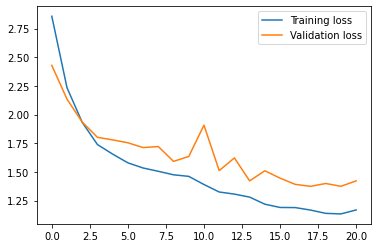

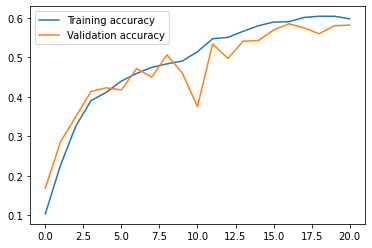

In [27]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(29, activation = "softmax")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training_generator,
                        epochs=40,
                        steps_per_epoch = total_train // batch_size, # si queremos usar más imágenes, aumentar este parametro y validation_steps
                        validation_data = validation_generator,
                        validation_steps = total_val // batch_size,
                        callbacks=callback)

  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio_reducido_data_augmentation.csv", test)

Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.
Epoch 1/60
257/257 [==============================] - 124s 481ms/step - loss: 6.5314 - accuracy: 0.0843 - val_loss: 2.6994 - val_accuracy: 0.1443
Epoch 2/60
257/257 [==============================] - 123s 478ms/step - loss: 2.6142 - accuracy: 0.1577 - val_loss: 2.4617 - val_accuracy: 0.1974
Epoch 3/60
257/257 [==============================] - 123s 479ms/step - loss: 2.4278 - accuracy: 0.1990 - val_loss: 2.2750 - val_accuracy: 0.2450
Epoch 4/60
257/257 [==============================] - 123s 479ms/step - loss: 2.2950 - accuracy: 0.2316 - val_loss: 2.5080 - val_accuracy: 0.2267
Epoch 5/60
257/257 [==============================] - 123s 478ms/step - loss: 2.0396 - accuracy: 0.2899 - val_loss: 2.0571 - val_accuracy: 0.2768
Epoch 6/60
257/257 [==============================] - 123s 478ms/step - loss: 1.9152 - accuracy: 0.3306 - val_loss: 2.1407 - val_accuracy: 0.2877
Epoch 7/60
257/257 [==================

2022/03/14 12:24:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


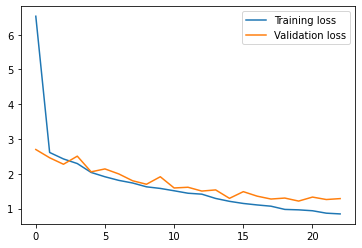

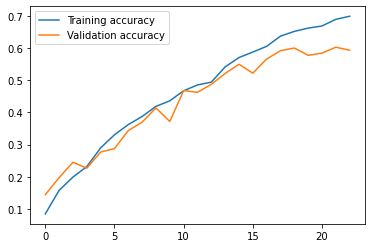

In [28]:
batch_size = 32

train_image_generator = ImageDataGenerator(rotation_range = 10, # en este problema tiene sentido que la imagen pueda ser tomada desde cualquier angulo
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           rescale = 1/.255,
                                           validation_split = 0.2)


training_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')


validation_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')

total_train = 8236
total_val = 2030


model = Sequential([
  tf.keras.layers.Conv2D(8, 2, activation='relu', input_shape=(224,224,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(100, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(125, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(29, activation = "softmax")
])

opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_entrenamiento_todo_dense")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=40,
                        validation_data=validation,
                        callbacks=callback)
  mostrarEvolucion(history)

predecir_guardar_test(model, "modelo_propio_2.csv", test)